In [3]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [4]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random

In [6]:
np.random.seed(0)

In [7]:
# Importing the data from pickle files
# with is used when you want to execute two statements and block of code in between
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [8]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [9]:
# Pre_conditions
assert(x_train.shape[0] == y_train.shape[0]), "The number of the images is not equal number of lables"
assert(x_val.shape[0] == y_val.shape[0]), "The number of the images is not equal number of lables"
assert(x_test.shape[0] == y_test.shape[0]), "The number of the images is not equal number of lables"
assert(x_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3"
assert(x_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3"
assert(x_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3"

In [10]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data.head(5))

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


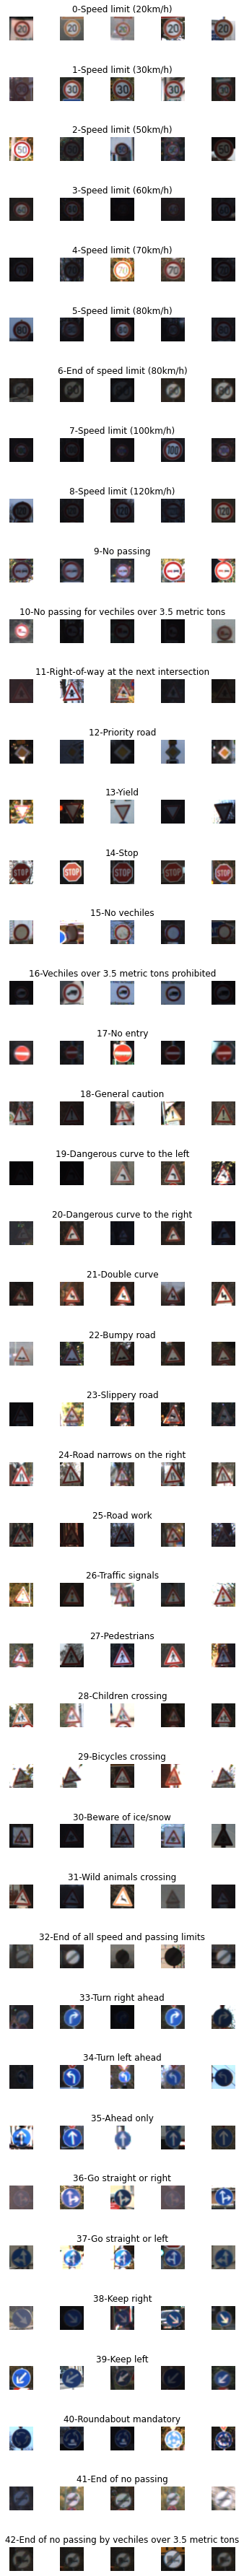

In [11]:
# Visualising the data
num_of_samples = []
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = x_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,len(x_selected-1)), :, :], cmap = plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j)+ "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

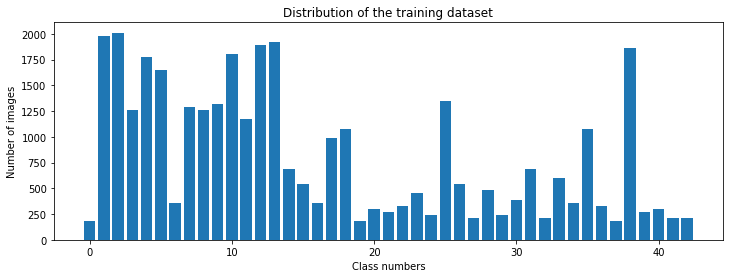

In [12]:
print(num_of_samples)
plt.figure(figsize = (12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title('Distribution of the training dataset')
plt.xlabel("Class numbers")
plt.ylabel("Number of images")

(32, 32, 3)
36


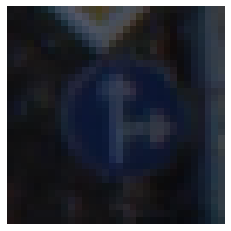

In [13]:
import cv2
plt.imshow(x_train[1000])
plt.axis('off')
print(x_train[1000].shape)
print(y_train[1000])

(32, 32)


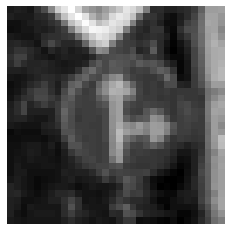

In [14]:
def grayscale (img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img
img = grayscale(x_train[1000])
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

(32, 32)


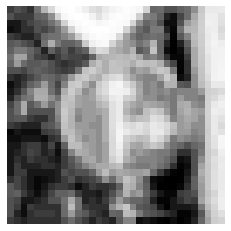

In [15]:
# Histogram equalizations to make color values equal for each pictures
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

In [16]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

# To preprocess correctly and completely
x_train = np.array(list(map(preprocessing, x_train)))
x_val = np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))

(34799, 32, 32)


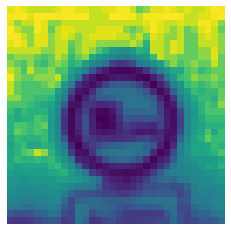

In [17]:
plt.imshow(x_train[random.randint(0, len(x_train) - 1)])
plt.axis('off')
print(x_train.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


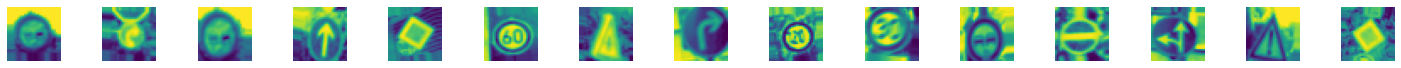

In [38]:
x_train = x_train.reshape(34799, 32, 32 ,1)
x_val = x_val.reshape(4410, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

# Data augmentation
from keras.preprocessing.image import ImageDataGenerator
# values are in percent of the image values
datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10)

datagen.fit(x_train)
# add 20 augmented images to each class
batches = datagen.flow(x_train, y_train, batch_size = 20)
x_batch, y_batch = next(batches)

fig, axe = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()
for i in range(15):
  axe[i].imshow(x_batch[i].reshape(32, 32))
  axe[i].axis('off')

In [19]:
# Convert class vector to binary class matrix
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [28]:
# Creating the model
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [29]:
model = leNet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [30]:
history = model.fit(x_train, y_train, epochs = 10, validation_data = (x_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 2s 19ms/step - loss: 2.3699 - accuracy: 0.3640 - val_loss: 0.7064 - val_accuracy: 0.8125
Epoch 2/10
87/87 [==============================] - 1s 16ms/step - loss: 0.6818 - accuracy: 0.7892 - val_loss: 0.2824 - val_accuracy: 0.9161
Epoch 3/10
87/87 [==============================] - 1s 17ms/step - loss: 0.3983 - accuracy: 0.8749 - val_loss: 0.1738 - val_accuracy: 0.9483
Epoch 4/10
87/87 [==============================] - 1s 17ms/step - loss: 0.2752 - accuracy: 0.9122 - val_loss: 0.1386 - val_accuracy: 0.9574
Epoch 5/10
87/87 [==============================] - 1s 17ms/step - loss: 0.2144 - accuracy: 0.9338 - val_loss: 0.1094 - val_accuracy: 0.9669
Epoch 6/10
87/87 [==============================] - 1s 17ms/step - loss: 0.1925 - accuracy: 0.9400 - val_loss: 0.0912 - val_accuracy: 0.9760
Epoch 7/10
87/87 [==============================] - 1s 17ms/step - loss: 0.1546 - accuracy: 0.9516 - val_loss: 0.0718 - val_accuracy: 0.9816
Epoch 8/10
87

Text(0.5, 1.0, 'Accuracy')

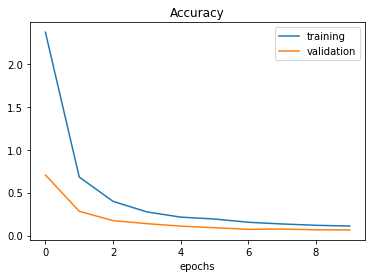

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('epochs')
plt.title('Accuracy')

Text(0.5, 1.0, 'Accuracy')

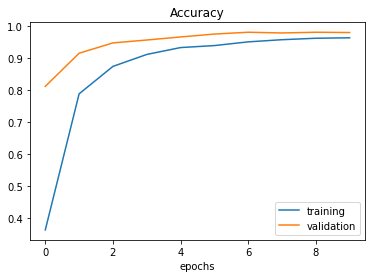

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.xlabel('epochs')
plt.title('Accuracy')

In [33]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13213637471199036
Test accuracy: 0.962232768535614


(32, 32)
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
predicted sign: [1]


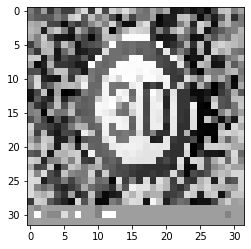

In [34]:
#fetch image
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))